In [63]:
import yfinance as yf
import pandas as pd

# 设置下载数据的时间范围为2021年一整年
start_date = '2021-01-01'
end_date = '2021-12-31'

# 设置测试数据的时间范围为2021年之后的一个月
# 注意：如果2021年12月的数据不完整，则测试数据的开始日期应为最后一个完整的交易日
test_start_date = '2022-01-01'
test_end_date = '2022-01-31'

# 定义沪深300指数的ticker
ticker = "000300.SS"

# 使用yfinance下载数据
data = yf.download(ticker, start=start_date, end=end_date)
test_data = yf.download(ticker, start=test_start_date, end=test_end_date)

# 检查数据
print(data.tail())  # 打印训练数据集的最后几行
print(test_data.head())  # 打印测试数据集的前几行

# 如果需要，可以将数据保存到CSV文件
# data.to_csv('training_data_2021.csv')
# test_data.to_csv('test_data_2022.csv')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2021-12-24  4953.060059  4964.910156  4905.979980  4921.339844  4921.339844   
2021-12-27  4918.149902  4939.689941  4894.160156  4919.319824  4919.319824   
2021-12-28  4923.689941  4959.140137  4913.600098  4955.959961  4955.959961   
2021-12-29  4958.649902  4958.649902  4883.479980  4883.479980  4883.479980   
2021-12-30  4882.160156  4940.180176  4878.649902  4921.509766  4921.509766   

            Volume  
Date                
2021-12-24  142700  
2021-12-27  124100  
2021-12-28  130500  
2021-12-29  113600  
2021-12-30  121600  
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
202

In [64]:
# 提取收盘价
data = data['Close'].values
test_data = test_data['Close'].values

# 打印以验证
print("Training close prices array length:", len(data))
print("Test close prices array length:", len(test_data))

Training close prices array length: 199
Test close prices array length: 19


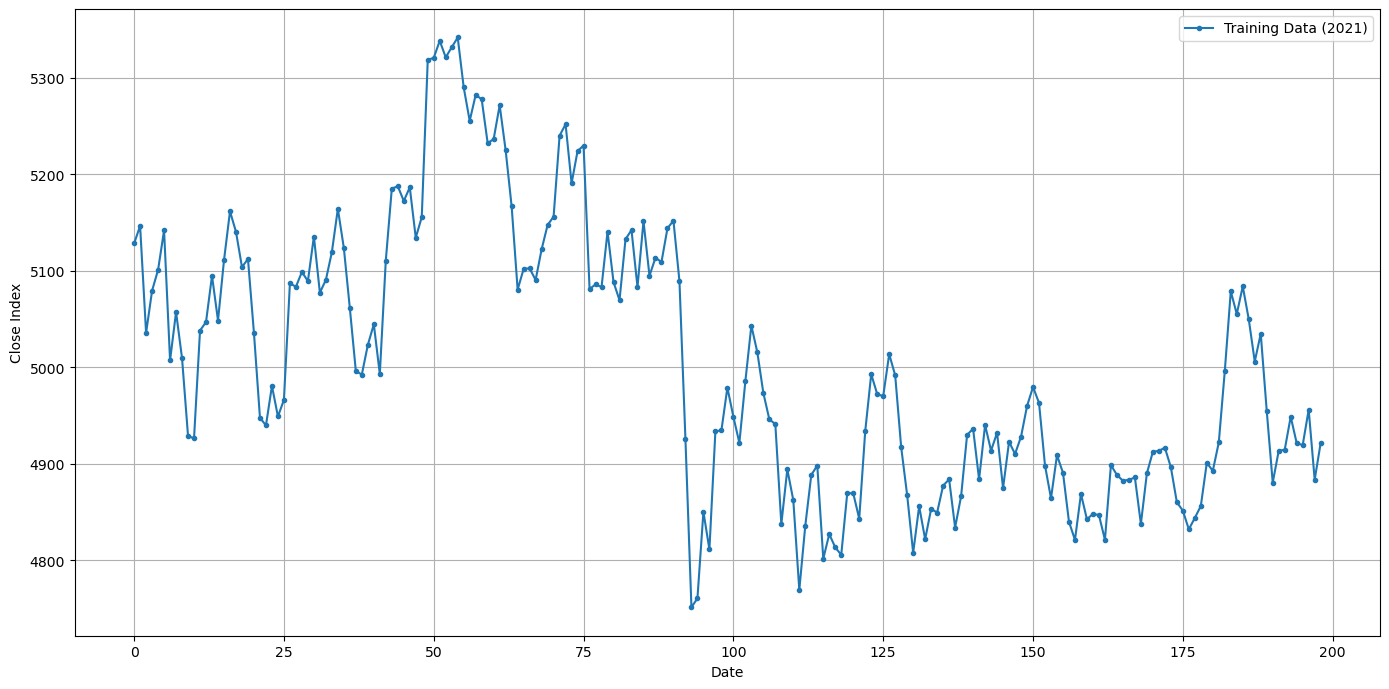

In [65]:
import matplotlib.pyplot as plt

# 绘制训练数据集的收盘价折线图
plt.figure(figsize=(14, 7))  # 设置图形的大小
plt.plot(data, label='Training Data (2021)', marker='.', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Close Index')
plt.grid(True)  # 显示网格
plt.legend()
plt.tight_layout()
plt.show()

In [66]:
import pywt
import matplotlib.pyplot as plt

# 查看全部可用小波基类型
print(pywt.families())
print(pywt.wavelist(family='sym',kind='discrete'))

['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor']
['sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']


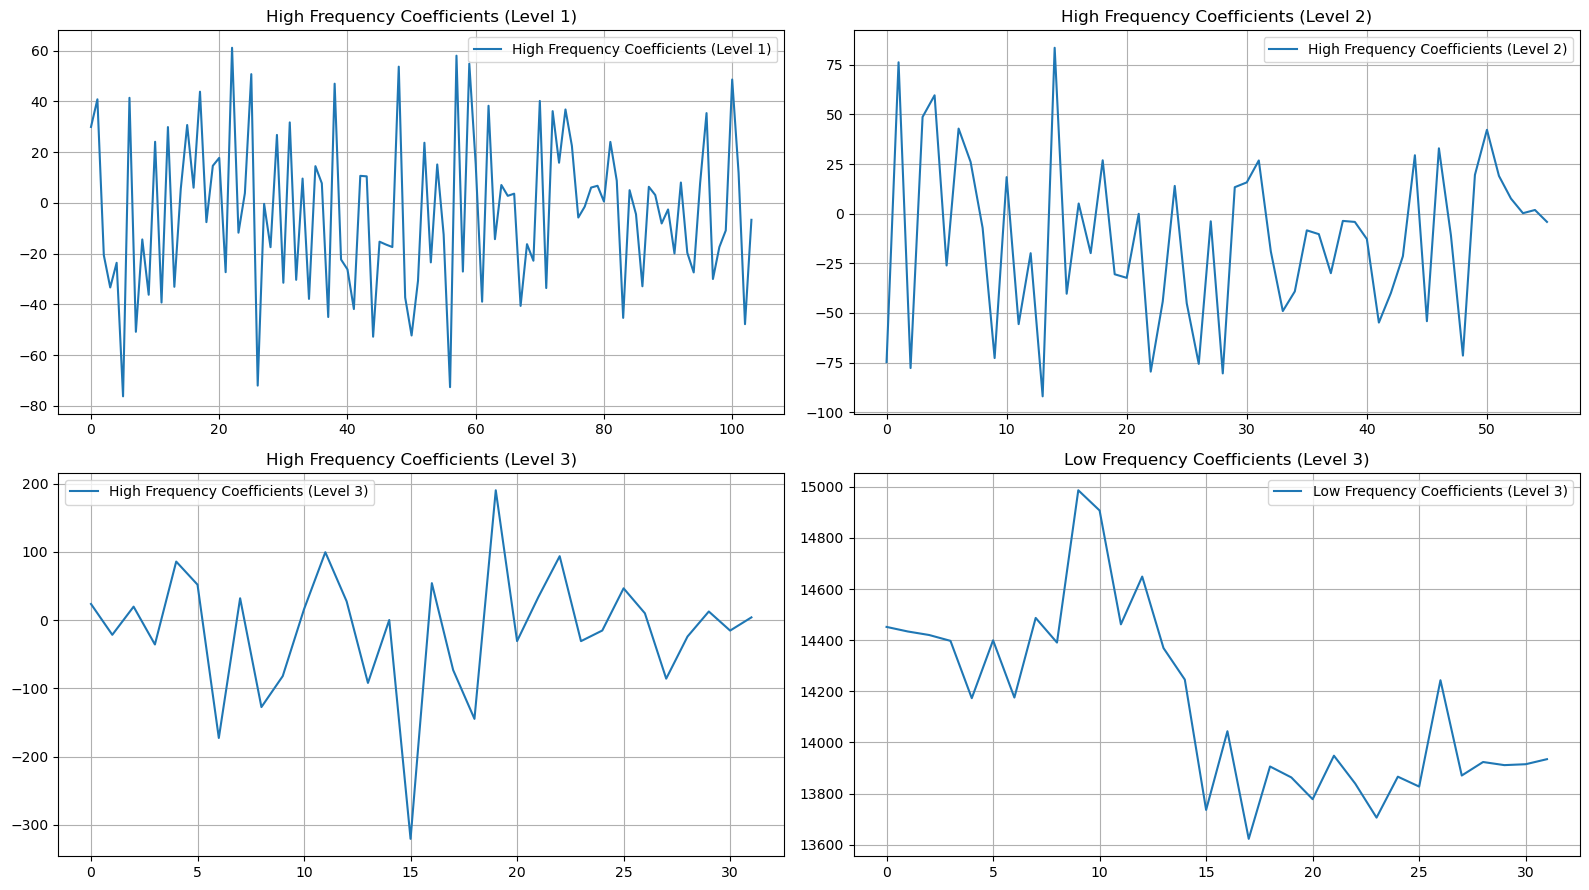

In [67]:
# 进行三层小波分解，这里选择 sym5 小波基函数
coeffs = pywt.wavedec(data, 'sym5', level=3)

# 分解得到的低频和高频系数
cA3, cD3, cD2, cD1 = coeffs

# 绘制低频和高频系数的图形
plt.figure(figsize=(16, 9))

# 绘制第一层高频系数
plt.subplot(2, 2, 1)
plt.plot(cD1, label='High Frequency Coefficients (Level 1)')
plt.title('High Frequency Coefficients (Level 1)')
plt.legend()
plt.grid(True)

# 绘制第二层高频系数
plt.subplot(2, 2, 2)
plt.plot(cD2, label='High Frequency Coefficients (Level 2)')
plt.title('High Frequency Coefficients (Level 2)')
plt.legend()
plt.grid(True)

# 绘制第三层高频系数
plt.subplot(2, 2, 3)
plt.plot(cD3, label='High Frequency Coefficients (Level 3)')
plt.title('High Frequency Coefficients (Level 3)')
plt.legend()
plt.grid(True)

# 绘制第三层低频系数
plt.subplot(2, 2, 4)
plt.plot(cA3, label='Low Frequency Coefficients (Level 3)')
plt.title('Low Frequency Coefficients (Level 3)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


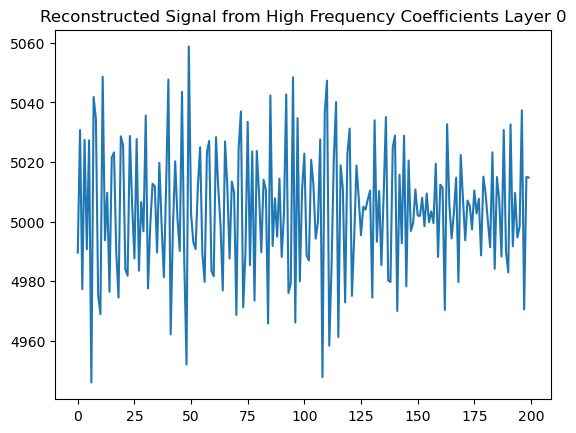

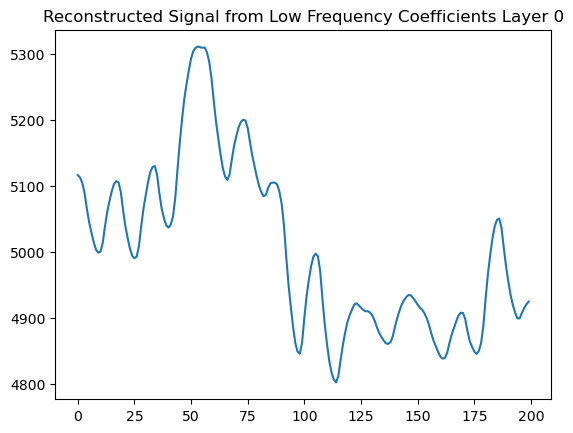

In [69]:
import pywt
import matplotlib.pyplot as plt

# 分解的层数
n = 3

# 为了重构，我们需要创建一个新的系数列表，其中只有目标层的系数是原来的，其他层的系数被置为零或适当的填充值
def reconstruct_signal_with_single_layer(coeffs, layer, n, reconstruct_low_freq=False):
    new_coeffs = [None] * (n + 1)
    for i in range(n + 1):
        if i == layer:
            new_coeffs[i] = coeffs[i]
        else:
            if i == 0 and reconstruct_low_freq:
                # 对于逼近系数，我们不能简单地使用零，因为它们的长度与原信号不同
                # 因此，我们用最后一层的逼近系数的平均值来填充
                new_coeffs[i] = np.ones_like(coeffs[i]) * np.mean(coeffs[i])
            else:
                # 对于细节系数，我们可以用零来代替
                new_coeffs[i] = np.zeros_like(coeffs[i])
    # 使用pywt.waverec进行重构
    return pywt.waverec(new_coeffs, 'sym5')

# 逐个层次重构信号并绘图 这里只展示第三层
for i in range(3, 4):
    # 重构高频频信号
    reconstructed_high = reconstruct_signal_with_single_layer(coeffs, i, n, reconstruct_low_freq=True)
    plt.figure()
    plt.plot(reconstructed_high)
    plt.title(f'Reconstructed Signal from High Frequency Coefficients Layer {n-i}')
    plt.show()

    # 重构低频信号
    reconstructed_low = reconstruct_signal_with_single_layer(coeffs, n-i, n)
    plt.figure()
    plt.plot(reconstructed_low)
    plt.title(f'Reconstructed Signal from Low Frequency Coefficients Layer {n-i}')
    plt.show()


In [70]:
len(reconstructed_low), len(reconstructed_high)

(200, 200)

In [71]:
from statsmodels.tsa.stattools import adfuller

# ADF检验函数
def adf_test(timeseries):
    print('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')  # 使用AIC来自动选择滞后长度
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    if dftest[1] <= 0.05:
        print("The series is likely stationary.")
    else:
        print("The series is likely non-stationary.")

# 对第三层的低频重构信号进行ADF检验
print("ADF Test for Low Frequency Reconstructed Signal:")
adf_test(reconstructed_low)

# 对第三层的高频重构信号进行ADF检验
print("\nADF Test for High Frequency Reconstructed Signal:")
adf_test(reconstructed_high)

ADF Test for Low Frequency Reconstructed Signal:
Results of Augmented Dickey-Fuller Test:
Test Statistic                  -1.234334
p-value                          0.658654
#Lags Used                      15.000000
Number of Observations Used    184.000000
Critical Value (1%)             -3.466398
Critical Value (5%)             -2.877380
Critical Value (10%)            -2.575214
dtype: float64
The series is likely non-stationary.

ADF Test for High Frequency Reconstructed Signal:
Results of Augmented Dickey-Fuller Test:
Test Statistic                -1.046562e+01
p-value                        1.324092e-18
#Lags Used                     1.500000e+01
Number of Observations Used    1.840000e+02
Critical Value (1%)           -3.466398e+00
Critical Value (5%)           -2.877380e+00
Critical Value (10%)          -2.575214e+00
dtype: float64
The series is likely stationary.


In [72]:
import pywt
import matplotlib.pyplot as plt

coeffs = pywt.wavedec(data, 'sym5', level=3)
reconstructed_signal = pywt.waverec(coeffs, 'sym5')

from sklearn.metrics import mean_squared_error
mean_squared_error(reconstructed_signal[:-1], data)

1.0784938780553195e-21

In [90]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# 使用函数寻找最佳的AR模型参数
best_model = ARIMA(reconstructed_low, order=(10, 0, 0)).fit()
ar7_model = ARIMA(data, order=(10, 0, 0)).fit()

MSE WT: 21840.82096288543 MSE AR(8): 40385.82717752777
RMSE WT: 147.78640317324673 RMSE AR(8): 200.96225311617047
RMSE LOSS: 53.17584994292375


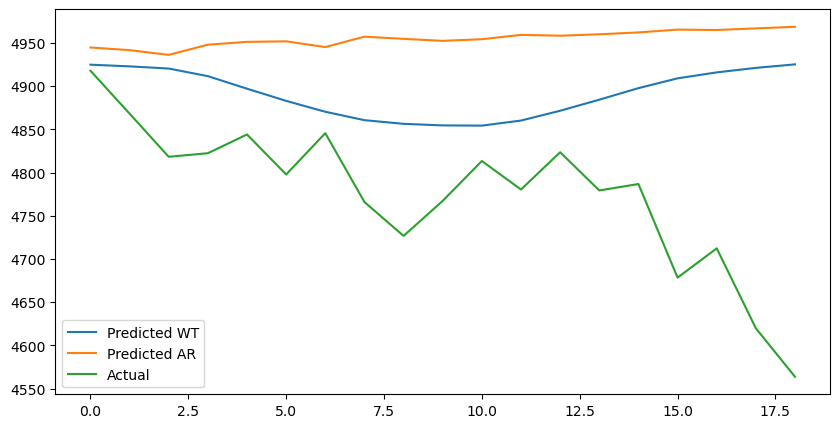

In [91]:
from sklearn.metrics import mean_squared_error

# 假设test_data是您用来对比的实际数据
# test_data = ...

# 使用最佳AR模型进行未来19个时间点的预测
predicted_values = best_model.forecast(steps=19)
predicted_values_2 = ar7_model.forecast(steps=19)

# 计算预测值与实际值之间的MSE
mse_1 = mean_squared_error(test_data, predicted_values)
mse_2 = mean_squared_error(test_data, predicted_values_2)

print(f"MSE WT: {mse_1} MSE AR(8): {mse_2}")

# 如果需要，您也可以计算其他指标，如MAE或RMSE
# 例如，计算RMSE（均方根误差）
rmse_1 = np.sqrt(mse_1)
rmse_2 = np.sqrt(mse_2)
print(f"RMSE WT: {rmse_1} RMSE AR(8): {rmse_2}")

print(f"RMSE LOSS: {rmse_2 - rmse_1}")

# 可视化预测值与实际值
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(predicted_values, label='Predicted WT')
plt.plot(predicted_values_2, label='Predicted AR')
plt.plot(test_data, label='Actual')
plt.legend()
plt.show()